# Часть 1: Тест Вильямса
## Двумерный многозвенный профиль

In [1]:
import os
import pandas as pd
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
#from matplotlib import pyplot
import itertools

%matplotlib inline

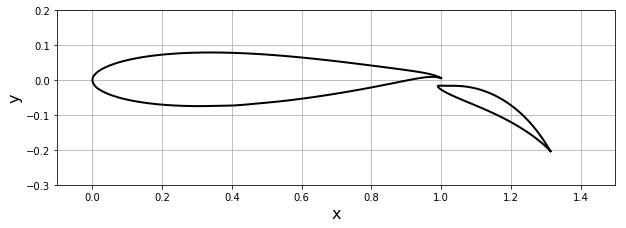

In [2]:
NumberOfPanels = 100 # количество панелей

## геометрия главной части
naca_main_filepath = os.path.join('resources', 'MainFoil_N={}.csv'.format(NumberOfPanels))
main_coord = pd.read_csv(naca_main_filepath, names=('x', 'y'))
x_main = main_coord.x.values
y_main = main_coord.y.values

## геометрия закрылки 
naca_flap_filepath = os.path.join('resources', 'FlapFoil_N={}.csv'.format(NumberOfPanels))
flap_coord = pd.read_csv(naca_flap_filepath, names=('x', 'y'))
x_flap = flap_coord.x.values
y_flap = flap_coord.y.values


## визуализация 
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.3, 0.2)

pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2);

In [3]:
class Panel:
    """
    Contains information related to a panel.
    """
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
        """
        self.xa, self.ya = xa, ya # начальная точка панели
        self.xb, self.yb = xb, yb # конечная точка панели
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # центр панели
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # длина панели
        
        # ориентация панели (угол между нормалью и осью x)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # расположение панели
        if self.beta <= numpy.pi:
            self.loc = 'upper' # верхняя поверхность
        else:
            self.loc = 'lower' # нижняя поверхность
        
        self.sigma = 0.0 # интенсивность источника
        self.vt = 0.0    # касательная скорость
        self.cp = 0.0    # коэффициент давления
        self.gamma = 0.0 # циркуляция

In [4]:
def define_panels(x, y, N):
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [5]:
# разбиваем геометрию на панели
panels_main = define_panels(x = x_main, y = y_main, N=NumberOfPanels)
panels_flap = define_panels(x = x_flap, y = y_flap, N=NumberOfPanels)

### Точечная геометрия профиля

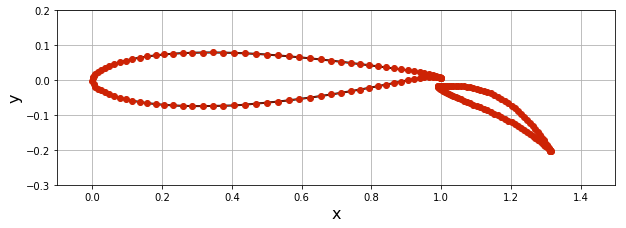

In [6]:
width = 10
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-0.3, 0.2)

pyplot.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)

# геометрия профиля крыла 
pyplot.plot(numpy.append([panel.xa for panel in panels_main], panels_main[0].xa),
            numpy.append([panel.ya for panel in panels_main], panels_main[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, \
            color='#CD2305')

# геометрия профиля закрылки
pyplot.plot(numpy.append([panel.xa for panel in panels_flap], panels_flap[0].xa),
            numpy.append([panel.ya for panel in panels_flap], panels_flap[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, \
            color='#CD2305');

In [7]:
class Freestream:
    """
    Freestream conditions.
    """
    def __init__(self, u_inf=1.0, alpha=0.0):
        """
        Sets the freestream speed and angle (in degrees).
        
        Parameters
        ----------
        u_inf: float, optional
            Freestream speed;
            default: 1.0.
        alpha: float, optional
            Angle of attack in degrees;
            default 0.0.
        """
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # градусы в радианы

In [8]:
# набегающий поток
freestream = Freestream(u_inf=1.0, alpha=0.0)

In [9]:
def integral(x, y, panel, dxdk, dydk):
    """
    Evaluates the contribution from a panel at a given point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Panel whose contribution is evaluated.
    dxdk: float
        Value of the derivative of x in a certain direction.
    dydk: float
        Value of the derivative of y in a certain direction.
    
    Returns
    -------
    Contribution from the panel at a given point (x, y).
    """
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [10]:
def source_contribution_normal(panels_first, panels_second):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels_first.size + panels_second.size, 
                     panels_first.size + panels_second.size), dtype=float)
    
    # вклад рассматриваемой панели в общее поле источников
    numpy.fill_diagonal(A, 0.5)
    # вклад остальных панелей
    for i, panel_i in enumerate(itertools.chain(panels_first,panels_second)):
        for j, panel_j in enumerate(itertools.chain(panels_first,panels_second)):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [11]:
def vortex_contribution_normal(panels_first, panels_second):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels_first.size + panels_second.size, 
                     panels_first.size + panels_second.size), dtype=float)
    
    # вклад от рассматриваемой панели в поле вихря
    numpy.fill_diagonal(A, 0.0)
    # вихревой вклад от всех остальных панелей
    for i, panel_i in enumerate(itertools.chain(panels_first,panels_second)):
        for j, panel_j in enumerate(itertools.chain(panels_first,panels_second)):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [12]:
A_source = source_contribution_normal(panels_main, panels_flap)
B_vortex = vortex_contribution_normal(panels_main, panels_flap)

In [13]:
def kutta_condition(A_source, B_vortex):
    global NumberOfPanels
    """
    Builds the Kutta condition array.
    """
    Na = NumberOfPanels
    b = numpy.empty((2, A_source.shape[0] + 2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    
    
    b[0,:-2] = B_vortex[0, :] + B_vortex[Na-1, :]
    b[1,:-2] = B_vortex[Na, :] + B_vortex[-1, :]
    
    b[0,-2] = - numpy.sum(A_source[0, :Na] + A_source[Na-1, :Na])
    b[0,-1] = - numpy.sum(A_source[0, Na:] + A_source[Na-1, Na:])
    
    b[1,-2] = - numpy.sum(A_source[Na, :Na] + A_source[-1, :Na])
    b[1,-1] = - numpy.sum(A_source[Na, Na:] + A_source[-1, Na:])
    
    return b

In [14]:
def build_singularity_matrix(A_source, B_vortex):
    global NumberOfPanels
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    Na = NumberOfPanels
    A = numpy.empty((A_source.shape[0] + 2, A_source.shape[1] + 2), dtype=float)
                    
    # матрица источников
    A[:-2, :-2] = A_source
    
    # матрица вихрей
    A[:-2,-2] = numpy.sum(B_vortex[:,:Na], axis=1).transpose() 
    A[:-2,-1] = numpy.sum(B_vortex[:,Na:], axis=1)
    
    # условие Кутты-Жуковского
    A[-2:, :] = kutta_condition(A_source, B_vortex) #последние 2 строки матрицы
    return A

In [15]:
def build_freestream_rhs(panels_first, panels_second, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels_first.size + panels_second.size + 2,dtype=float)
    # вклад от набегающего потока в каждую панель
    for i, panel in enumerate(itertools.chain(panels_first,panels_second)):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
        
    # вклад от набегающего потока в условии Кутты-Жуковского
    b[-2] = -freestream.u_inf*(numpy.sin(freestream.alpha-panels_first[0].beta)
                               +numpy.sin(freestream.alpha-panels_first[-1].beta))
    b[-1] = -freestream.u_inf*(numpy.sin(freestream.alpha-panels_second[0].beta)
                               +numpy.sin(freestream.alpha-panels_second[-1].beta))
    return b

In [16]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels_main, panels_flap, freestream)

### Интенсивности источников и вихря

In [17]:
strengths = numpy.linalg.solve(A, b)

# заполняем интенсивности на кажой панели
for i , panel in enumerate(panels_main):
    panel.sigma = strengths[i]
    panel.gamma = strengths[-2]
for i , panel in enumerate(panels_flap):
    panel.sigma = strengths[i+panels_flap.size]
    panel.gamma = strengths[-1]
    

### Коэффициент давления на поверхности 

In [18]:
def compute_tangential_velocity(panels_first,panels_second, freestream, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    """
    A = numpy.empty((panels_first.size + panels_second.size, 
                     panels_first.size + panels_second.size + 2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    A[:, :-2] = B_vortex
    # матрица вкладов вихрей в тангенциальную составляющую скорости
    # противоположна по знаку
    # матрице вкладов источников в нормальную составляющую скорости
    
    ## вклад основной части
    A[:, -2] = -numpy.sum(A_source[:,:panels_first.size], axis=1)
    ## вклад закрылки 
    A[:, -1] = -numpy.sum(A_source[:,panels_first.size:], axis=1)
    
    # добавляем набегающий поток
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in itertools.chain(panels_first,panels_second)])
    
    ## достаем гаммы из каждой панели
    strengths = numpy.empty( (panels_first.size + panels_second.size+2,),dtype=float)
    for i, panel in enumerate(itertools.chain(panels_first,panels_second)):
        strengths[i] = panel.sigma
    strengths[-2] = panels_first[0].gamma
    strengths[-1] = panels_second[0].gamma
    
    ## вычисляем тангенцальную компоненту
    tangential_velocities = numpy.dot(A, strengths) + b
    
    ## каждой панели раскидываем скорости
    for i, panel in enumerate(itertools.chain(panels_first,panels_second)):
        panel.vt = tangential_velocities[i]
        

In [19]:
# касательная компонента скорости на каждой панели
compute_tangential_velocity(panels_main, panels_flap, freestream, A_source, B_vortex)

In [20]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [21]:
# коэффициент давления на поверхности
compute_pressure_coefficient(panels_main, freestream)
compute_pressure_coefficient(panels_flap, freestream)

## Коэффициент давления

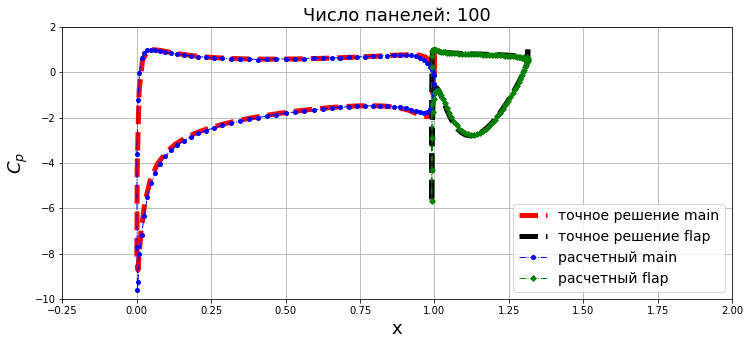

In [22]:
# теоретическая геометрия основной части
naca_filepath = os.path.join('resources', 'Cp_Main_theoretical.csv')
with open (naca_filepath, 'r') as file_name:
    x_theoretical_main, cp_theoretical_main = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)

# теоретическая геометрия закрылки
naca_filepath = os.path.join('resources', 'Cp_Flap_theoretical.csv')
with open (naca_filepath, 'r') as file_name:
    x_theoretical_flap, cp_theoretical_flap = numpy.loadtxt(file_name, dtype=float,\
                         delimiter=',', unpack=True)
    
    
pyplot.figure(figsize=(12, 5))
pyplot.grid()
pyplot.xlabel('x', fontsize=18)
pyplot.ylabel('$C_p$', fontsize=18)
pyplot.title('Число панелей: {}'.format(NumberOfPanels), fontsize=18)
pyplot.xlim(-0.25, 2)
pyplot.ylim(-10, 2)

pyplot.plot(x_theoretical_main, cp_theoretical_main, color='red', linestyle='--',
            linewidth=5, label='точное решение main')
pyplot.plot(x_theoretical_flap, cp_theoretical_flap, color='black', linestyle='--',
            linewidth=5, label='точное решение flap')
pyplot.plot(x_main[:-1], [panel.cp for panel in panels_main], color='blue', linestyle='-.',
            marker='o', markersize=4, linewidth=1, label='расчетный main')
pyplot.plot(x_flap[:-1], [panel.cp for panel in panels_flap], color='green', linestyle='-.',
            marker='D', markersize=4, linewidth=1, label='расчетный flap')
pyplot.legend(loc='best', prop={'size':14});

In [23]:
accuracy = sum([panel.sigma*panel.length for panel in itertools.chain(panels_main,panels_flap)])
print('суммарная интенсивность особенностей: {:.6f}'.format(accuracy))

суммарная интенсивность особенностей: -0.001748


In [24]:
# вычисляем хорду и коэффициент подъемной силы
c_main = abs(max(panel.xa for panel in panels_main)
        - min(panel.xa for panel in panels_main))
c_flap = abs(max(panel.xa for panel in panels_flap)
        - min(panel.xa for panel in panels_flap))

Cl = ( panels_main[0].gamma*sum(panel.length for panel in panels_main) + 
       panels_flap[0].gamma*sum(panel.length for panel in panels_flap) ) / (0.5*freestream.u_inf*(c_main+ c_flap) )
print('коэффициент подъемной силы: CL = {:.4f}'.format(Cl))

коэффициент подъемной силы: CL = 2.8143


In [25]:
F_x_main = 0.0
F_y_main = 0.0

for panel in panels_main:
    F_x_main += panel.cp*numpy.cos(panel.beta)*panel.length
    F_y_main += -panel.cp*numpy.sin(panel.beta)*panel.length
    
F_x_flap = 0.0
F_y_flap = 0.0

for panel in panels_flap:
    F_x_flap += panel.cp*numpy.cos(panel.beta)*panel.length
    F_y_flap += -panel.cp*numpy.sin(panel.beta)*panel.length

In [26]:
F_x = F_x_main + F_x_flap
F_y = F_y_main + F_y_flap

print(round(F_x,4), round(F_y,4))

0.0108 3.6977


In [27]:
Cy = 0.0
for i, panel in enumerate(itertools.chain(panels_main,panels_flap)):
    Cy += (panel.xb - panel.xa)*panel.cp
print("Подъемная сила = {:.4f}".format(Cy))

Cx = 0.0
for i, panel in enumerate(itertools.chain(panels_main,panels_flap)):
    Cx += (panel.yb - panel.ya)*panel.cp
print("Сила сопротивления = {:.3f}".format(Cx))

Подъемная сила = 3.6977
Сила сопротивления = 0.011


In [94]:
print('''Теоретические значения коэффициентов подъемной силы и сопротивления для этого случая:
3.7386 и 0 соответственно (обезразмерены на скоростной напор).\n''')

print('''Значения коэффициентов подъемной силы и сопротивления для N=100:
3.5693 и 0.012 соответственно (обезразмерены на скоростной напор).\n''')

print('''Значения коэффициентов подъемной силы и сопротивления для N=200:
3.5693 и 0.012 соответственно (обезразмерены на скоростной напор).\n''')

Теоретические значения коэффициентов подъемной силы и сопротивления для этого случая:
3.7386 и 0 соответственно (обезразмерены на скоростной напор).

Значения коэффициентов подъемной силы и сопротивления для N=100:
3.5693 и 0.012 соответственно (обезразмерены на скоростной напор).

Значения коэффициентов подъемной силы и сопротивления для N=200:
3.5693 и 0.012 соответственно (обезразмерены на скоростной напор).

